# RECol: Toy Example

## Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

## Data Generation
Generating data and labeling outliers according to underlying relationship within the data.

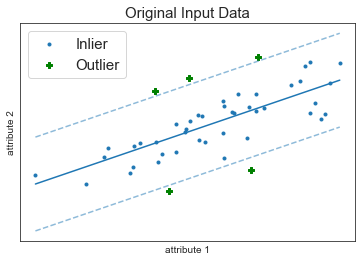

In [2]:
np.random.seed(1337)

# random data with linear relationship
n=42
x = 3 + np.random.randn(n)
y = 1.5*x + 3 + np.random.randn(n)

# add some outliers along the middle...
x = np.hstack((x, [2.0, 2.2,  2.5, 3.4, 3.5]))
y = np.hstack((y, [9.2, 3.0, 10.0, 4.3, 11.3]))

# calc linreg model
linreg = sklearn.linear_model.LinearRegression().fit(x.reshape(-1, 1), y)
y_pred = linreg.predict(x.reshape(-1,1))
stdev = np.std(y_pred - y)
lines = np.array(sorted(zip(x, y_pred)))[[0,-1]]

# colors:
cmap1 = np.array([
    'C0',  # true inliers
    'g',  # correctly identified as outlier
])
# markers:
mmap1 = '.P'
labels1 = [
    "Inlier",
    "Outlier",
]

# define points outside of 2*stdev interval as outliers:
outliers = (y_pred - y)**2 > (2*stdev)**2
codes1 = np.array(outliers)  # coding of the point for cmap1 and mmap1

# Plotting original data and labels
# reg lines and 2*stdev interval
plt.plot(lines[:, 0], lines[:, 1], color='C0')
plt.plot(lines[:, 0], lines[:, 1] + 2*stdev, '--', color='C0', alpha=.5)
plt.plot(lines[:, 0], lines[:, 1] - 2*stdev, '--', color='C0', alpha=.5)
for i in range(2):
    mask = codes1 == i
    plt.scatter(x[mask], y[mask], c=cmap1[i], marker=mmap1[i], label=labels1[i])
plt.title('Original Input Data', fontdict = {'fontsize' : 15})
plt.xlabel('attribute 1')
plt.ylabel('attribute 2')
plt.legend(loc='best', prop = { 'size':15})
plt.xticks([])
plt.yticks([])
plt.show()

## Vanilla OD Approach
Directly applying a standard outlier detection algorithm (Isolation Forest) to the input data. 

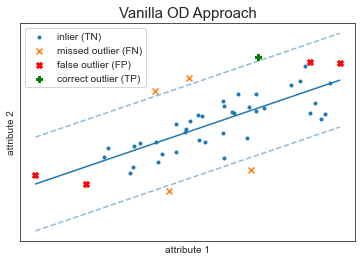

In [3]:
# calcuating outlier detector
X = np.column_stack((x, y))
od = IForest(n_estimators=25, contamination=0.1).fit(X)
od_pred = od.predict(X)

# colors:
cmap = np.array([
    'C0',  # true inliers
    'C1',  # true outliers
    'r',  # falsely identified as outlier
    'g',  # correctly identified as outlier
])
# markers:
mmap = '.xXP'
labels = [
    "inlier (TN)",
    "missed outlier (FN)",
    "false outlier (FP)",
    "correct outlier (TP)",
]

errs = (y_pred - y)
outliers = (y_pred - y)**2 > (2*stdev)**2
codes = outliers + 2*od_pred  # coding of the point for cmap and mmap


# Plotting Predicted Outliers from OD Algorithm
# reg lines and 2stdev interval
plt.plot(lines[:, 0], lines[:, 1], color='C0')
plt.plot(lines[:, 0], lines[:, 1] + 2*stdev, '--', color='C0', alpha=.5)
plt.plot(lines[:, 0], lines[:, 1] - 2*stdev, '--', color='C0', alpha=.5)
for i in range(4):
    mask = codes == i
    plt.scatter(x[mask], y[mask], c=cmap[i], marker=mmap[i], label=labels[i])

plt.title('Vanilla OD Approach', fontdict = {'fontsize' : 15})
plt.xlabel('attribute 1')
plt.ylabel('attribute 2')
plt.legend(loc='best', prop = { 'size':10 })
plt.xticks([])
plt.yticks([])
plt.show()

#### Vanilla OD Approach Output Summary:
- OD algorithm is largely focusing on labeling datapoints as outliers that are far away from others in the data space but, it is neglecting the simple underlying relationships in the data in our case.
- As a result there are more misclassifications in the output: More orange and red points, but less number of green points.

## RECol Approach

### RECol Space

Calculating a Reconstruction Error Column for each feature in the original data in a leave one out fashion

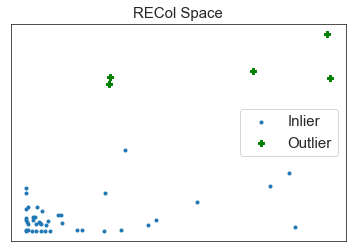

In [4]:
# Using a Supervised Model to compute the reconstruction error for each feature 
# Input: All other features from the input data
# Label or Ground Truth: Selected feature
recon_lin = LinearRegression()
recon_lin.fit(x.reshape(-1, 1), y)
y_fit = recon_lin.predict(x.reshape(-1, 1))

recon_lin.fit(y.reshape(-1, 1), x)
x_fit = recon_lin.predict(y.reshape(-1, 1))

# Calculating Reconstruction error between model prediction and labels
re1 = (x - x_fit)**2
re2 = (y - y_fit)**2
re_features = np.column_stack((re1, re2))

# Plotting Reconstruction error space
for i in range(2):
    mask = codes1 == i
    plt.scatter(re1[mask], re2[mask], c=cmap1[i], marker=mmap1[i], label=labels1[i])
plt.title('RECol Space', fontdict = {'fontsize' : 15})
plt.legend(loc='best', prop = { 'size':15})
plt.xticks([])
plt.yticks([])
plt.show()

### Concatenate Original Data with RECols

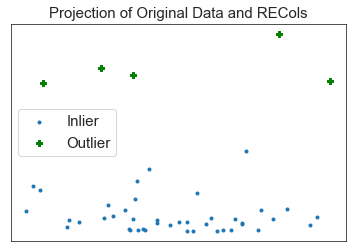

In [5]:
# Concatenating RECols with Original Data
combined_features = np.column_stack((X, re_features))

# project back to 2D space
res = PCA(n_components = 2).fit_transform(combined_features)

cmap1 = np.array([
    'C0',  # true inliers
    'g',  # correctly identified as outlier
])
# markers:
mmap1 = '.P'
labels1 = [
    "Inlier",
    "Outlier",
]

#codes1 = np.array(outliers)

# Plotting Concatenated Data
for i in range(2):
    mask = codes1 == i
    plt.scatter(res[:, 1][mask], res[:, 0][mask], c=cmap1[i], marker=mmap1[i], label=labels1[i])
plt.title('Projection of Original Data and RECols', fontdict = {'fontsize' : 15})
plt.legend(loc='best', prop = { 'size':15})
plt.xticks([])
plt.yticks([])
plt.show()

### Applying OD to Concatenated Data

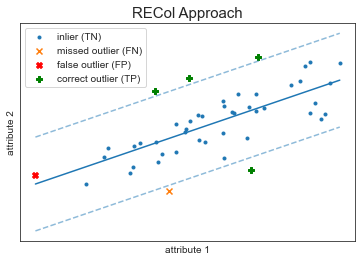

In [6]:
# Apply a standard Outlier Detection Algorithm to combined data
od.fit(combined_features)
y_pred_combined = od.predict(combined_features)

# Plotting Original Data and Labels
# reg lines and 2*stdev interval
plt.plot(lines[:, 0], lines[:, 1], color='C0')
plt.plot(lines[:, 0], lines[:, 1] + 2*stdev, '--', color='C0', alpha=.5)
plt.plot(lines[:, 0], lines[:, 1] - 2*stdev, '--', color='C0', alpha=.5)
codes = outliers + 2*y_pred_combined
for i in range(4):
    mask = codes == i
    plt.scatter(x[mask], y[mask], c=cmap[i], marker=mmap[i], label=labels[i])
plt.title('RECol Approach', fontdict = {'fontsize' : 15})
plt.xlabel('attribute 1')
plt.ylabel('attribute 2')
plt.legend(loc='best', prop = { 'size':10})
plt.xticks([])
plt.yticks([])
plt.show()

**RECol Approach Output Summary:**

Concatenation of the RECols to the original data helps the OD algorithm to classify points as outliers that deviate from the underlying relationship.